# PyCIEMSS optimize interface with different intervention types

### Load dependencies and interfaces

In [1]:
import os
import torch
import pyro
import numpy as np
from typing import Dict, List
import pyciemss
import pyciemss.visuals.plots as plots
import time

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

smoke_test = "CI" in os.environ

### Select model

In [2]:
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
model_opt1 = os.path.join(MODEL_PATH, "SIR_stockflow.json")
model_opt2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")

### Set parameters for sampling

In [30]:
start_time = 0.0
end_time_SIR = 40.0
end_time_SEIRHD = 60.0
logging_step_size = 1.0
num_samples = 3 if smoke_test else 1000
num_samples_ouu = 10 if smoke_test else 1000 # controls accuracy of risk estimation in each optimization iteration
maxiter = 0 if smoke_test else 3    # maximum number of restarts of local convex optimizer leading to maxiter+1 local optimizations
maxfeval = 1 if smoke_test else 30  # maximum number of function evaluations in each instance of local convex optimization

### Define QoI function

In [4]:
def obs_nday_average_qoi(
    samples: Dict[str, torch.Tensor], contexts: List, ndays: int = 7
) -> np.ndarray:
    """
    Return estimate of last n-day average of each sample.
    samples is is the output from a Pyro Predictive object.
    samples[VARIABLE] is expected to have dimension (nreplicates, ntimepoints)
    Note: last ndays timepoints is assumed to represent last n-days of simulation.
    ndays = 1 leads to using the value at the end of the simulation.
    """
    dataQoI = samples[contexts[0]].detach().numpy()
    return np.mean(dataQoI[:, -ndays:], axis=1)

### Baseline samples before optimization from model 1

Time taken:  3.2530856132507324
Risk associated with QoI: [488.838154296875]


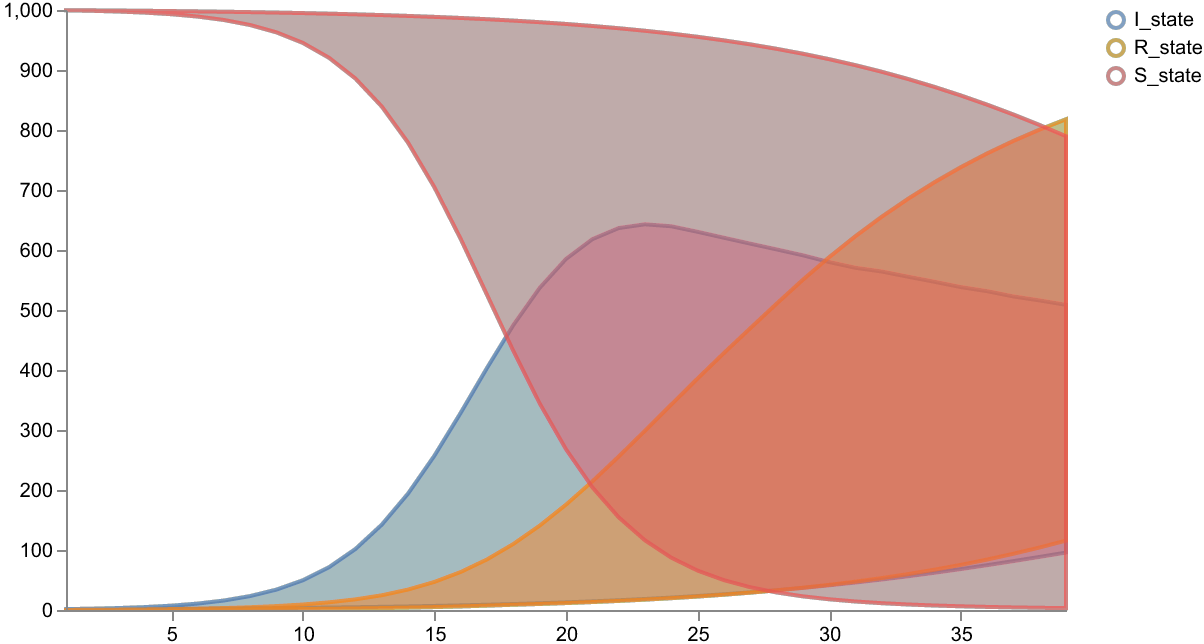

In [31]:
start_t = time.time()
sample_results1 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results1["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Baseline samples before optimization from model 2

Time taken:  9.450354814529419
Risk associated with QoI: [4748819.739999998]


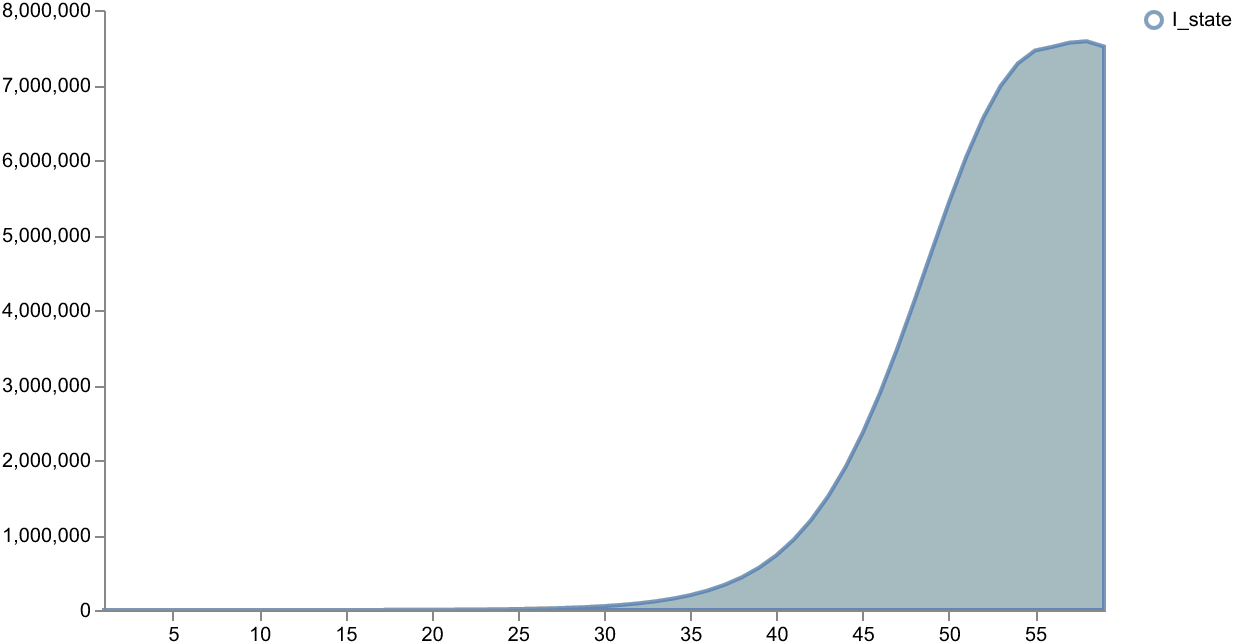

In [32]:
start_t = time.time()
sample_results2 = pyciemss.sample(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    num_samples,
    start_time=start_time,
    # solver_method="dopri5",
    solver_method="rk4",
    solver_options={"step_size": 1.}
)
print("Time taken: ", time.time()-start_t)
print("Risk associated with QoI:", sample_results2["risk"]["I_state"]["risk"])
# Plot results for all states
schema = plots.trajectories(sample_results2["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with single intervention
### Optimizing a single parameter value (SIR)
Minimum change in the intervention parameter from the current value to get infections below 300 individuals at 40 days for SIR model

In [7]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(1.0)]
intervened_params = ["p_cbeta"]
p_cbeta_current = 0.35
initial_guess_interventions = 0.15
bounds_interventions = [[0.1], [0.5]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.abs(p_cbeta_current - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

  0%|          | 0/60 [00:00<?, ?it/s]

[0.15]
Risk:  53.392703704833984
[0.15]


  2%|▏         | 1/60 [00:05<05:13,  5.32s/it]

Risk:  53.392703704833984
[0.19]


  3%|▎         | 2/60 [00:07<03:12,  3.31s/it]

Risk:  180.94763305664063
[0.19597464]


  5%|▌         | 3/60 [00:10<03:07,  3.29s/it]

Risk:  209.86927246093748
[0.19393584]


  7%|▋         | 4/60 [00:12<02:43,  2.93s/it]

Risk:  199.76724304199217
[0.19424834]


  8%|▊         | 5/60 [00:15<02:41,  2.94s/it]

Risk:  201.30099182128905
[0.19398327]


 10%|█         | 6/60 [00:18<02:29,  2.77s/it]

Risk:  199.9996875
[0.19399303]


 12%|█▏        | 7/60 [00:21<02:34,  2.92s/it]

Risk:  200.04751586914062
[0.19425726]
Risk:  201.34479431152343
[0.19425726]


 13%|█▎        | 8/60 [00:26<03:02,  3.51s/it]

Risk:  201.34479431152343
[0.23425726]


 15%|█▌        | 9/60 [00:28<02:33,  3.02s/it]

Risk:  405.2231964111328
[0.18925726]


 17%|█▋        | 10/60 [00:30<02:20,  2.80s/it]

Risk:  177.5058428955078
[0.19488226]


 18%|█▊        | 11/60 [00:32<02:11,  2.69s/it]

Risk:  204.42876525878904
[0.19398472]


 20%|██        | 12/60 [00:35<02:12,  2.76s/it]

Risk:  200.00677490234375
[0.19394566]


 22%|██▏       | 13/60 [00:38<02:02,  2.61s/it]

Risk:  199.81536193847654
[0.19398972]


 23%|██▎       | 14/60 [00:40<01:51,  2.41s/it]

Risk:  200.03131591796875
[0.28568986]
Risk:  504.4845275878906
[0.28568986]


 25%|██▌       | 15/60 [00:44<02:15,  3.01s/it]

Risk:  504.4845275878906
[0.32568986]


 27%|██▋       | 16/60 [00:46<02:03,  2.80s/it]

Risk:  475.1239855957031
[0.36568986]


 28%|██▊       | 17/60 [00:48<01:51,  2.59s/it]

Risk:  427.3744842529297
[0.40568986]


 30%|███       | 18/60 [00:51<01:44,  2.48s/it]

Risk:  384.4240167236328
[0.38568986]


 32%|███▏      | 19/60 [00:53<01:37,  2.37s/it]

Risk:  404.86385131835937
[0.39568986]


 33%|███▎      | 20/60 [00:55<01:32,  2.31s/it]

Risk:  394.37196960449216
[0.40568986]


 35%|███▌      | 21/60 [00:57<01:26,  2.22s/it]

Risk:  384.4240167236328
[0.41568986]


 37%|███▋      | 22/60 [00:59<01:25,  2.26s/it]

Risk:  375.0219189453125
[0.42568986]


 38%|███▊      | 23/60 [01:02<01:27,  2.37s/it]

Risk:  366.15611267089844
[0.43568986]


 40%|████      | 24/60 [01:05<01:31,  2.55s/it]

Risk:  357.80692016601563
[0.44568986]


 42%|████▏     | 25/60 [01:08<01:30,  2.58s/it]

Risk:  349.95359985351564
[0.45568986]


 43%|████▎     | 26/60 [01:10<01:26,  2.54s/it]

Risk:  342.56408142089845
[0.46568986]


 45%|████▌     | 27/60 [01:13<01:29,  2.72s/it]

Risk:  335.6105084228516
[0.47568986]


 47%|████▋     | 28/60 [01:16<01:24,  2.63s/it]

Risk:  329.0650872802734
[0.48568986]


 48%|████▊     | 29/60 [01:18<01:19,  2.57s/it]

Risk:  322.9006884765625
[0.49568986]


 50%|█████     | 30/60 [01:21<01:18,  2.61s/it]

Risk:  317.0912432861328
[0.50568986]
[0.50068986]
[0.49318986]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
 55%|█████▌    | 33/60 [01:24<00:45,  1.69s/it]

Risk:  318.5116961669922
[0.49693986]


 58%|█████▊    | 35/60 [01:26<01:02,  2.48s/it]

Risk:  316.3887744140625
Optimal policy: tensor([0.1940], dtype=torch.float64)
{'policy': tensor([0.1940], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.15601673345676997
                          x: [ 1.940e-01]
                        nit: 2
      minimization_failures: 2
                       nfev: 34
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.15601673345676997
                                   x: [ 1.940e-01]
                                nfev: 7
                               maxcv: 0.0}


#### Sample using optimal policy as intervention

Intervention:  {1.0: {'p_cbeta': tensor(0.1940)}}


Risk associated with QoI: [197.49244567871094]


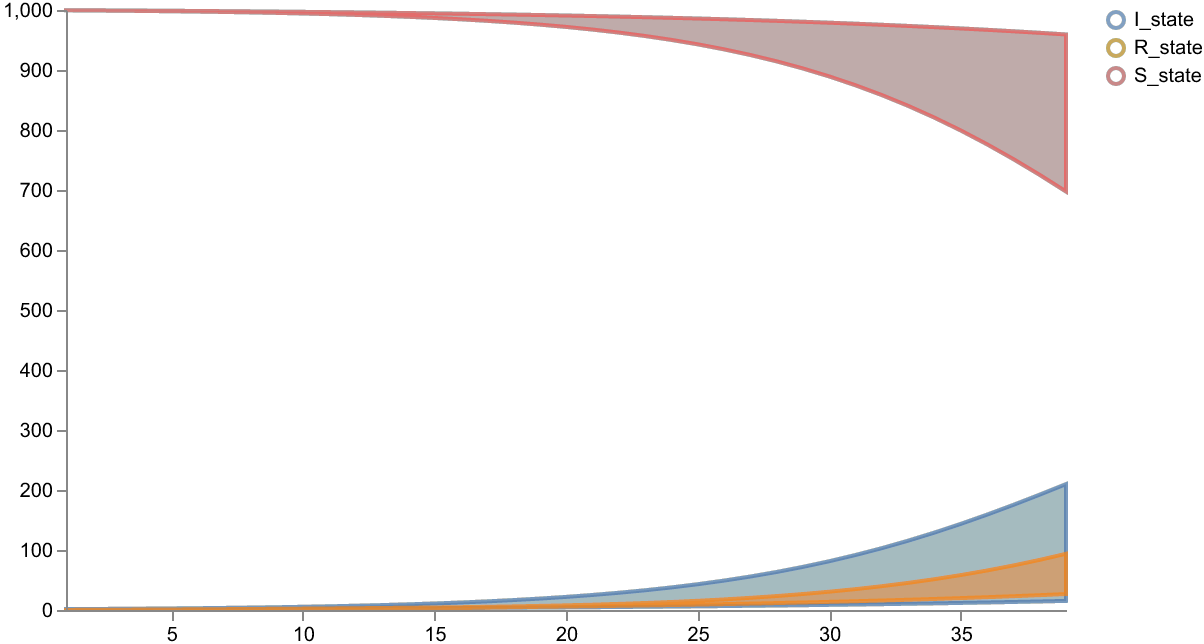

In [8]:
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))
result1 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
# display(result1["data"])
print("Risk associated with QoI:", result1["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)


### Optimizing the start time for a single intervention (SIR)
Maximum delay in the intervention to get infections below 300 individuals at 40 days for SIR model

In [9]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["p_cbeta"]
initial_guess_interventions = 5.
bounds_interventions = [[1.], [39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 200.0
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -x

# Run optimize interface
opt_result2 = pyciemss.optimize(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result2["policy"])
print(opt_result2)
print("Intervention: ", static_parameter_interventions(opt_result2["policy"]))

  0%|          | 0/60 [00:00<?, ?it/s]

[5.]
Risk:  126.89316650390624
[5.]


  2%|▏         | 1/60 [00:04<04:37,  4.71s/it]

Risk:  126.89316650390624
[8.8]


  3%|▎         | 2/60 [00:07<03:17,  3.41s/it]

Risk:  230.5316015625
[7.68053032]


  5%|▌         | 3/60 [00:10<03:02,  3.21s/it]

Risk:  199.56992553710936
[7.91803032]


  7%|▋         | 4/60 [00:12<02:41,  2.88s/it]

Risk:  206.26942260742186
[7.71021782]


  8%|▊         | 5/60 [00:14<02:25,  2.65s/it]

Risk:  200.40821044921873
[7.69576122]


 10%|█         | 6/60 [00:16<02:12,  2.46s/it]

Risk:  200.00000976562498
[7.69390575]


 12%|█▏        | 7/60 [00:19<02:11,  2.48s/it]

Risk:  199.947626953125
[7.69599315]


 13%|█▎        | 8/60 [00:21<02:07,  2.45s/it]

Risk:  200.00657287597653
[7.69573223]


 15%|█▌        | 9/60 [00:24<02:02,  2.40s/it]

Risk:  199.9991857910156
[7.69576622]


 17%|█▋        | 10/60 [00:26<02:04,  2.49s/it]

Risk:  200.00016784667966
[10.73352897]
Risk:  276.83643127441405
[10.73352897]


 18%|█▊        | 11/60 [00:31<02:40,  3.28s/it]

Risk:  276.83643127441405
[14.53352897]


 20%|██        | 12/60 [00:34<02:22,  2.97s/it]

Risk:  325.58774536132813
[6.93352897]


 22%|██▏       | 13/60 [00:36<02:15,  2.87s/it]

Risk:  178.50229248046872
[7.76428103]


 23%|██▎       | 14/60 [00:39<02:03,  2.69s/it]

Risk:  201.93427246093748
[7.88303103]


 25%|██▌       | 15/60 [00:41<01:55,  2.56s/it]

Risk:  205.28330139160155
[7.69569552]


 27%|██▋       | 16/60 [00:44<01:54,  2.61s/it]

Risk:  199.99815979003904
[7.71053927]


 28%|██▊       | 17/60 [00:46<01:54,  2.65s/it]

Risk:  200.41728759765624
[7.69755099]


 30%|███       | 18/60 [00:48<01:44,  2.50s/it]

Risk:  200.0505529785156
[7.69592746]


 32%|███▏      | 19/60 [00:51<01:37,  2.38s/it]

Risk:  200.00473022460935
[7.69576048]


 33%|███▎      | 20/60 [00:53<01:40,  2.50s/it]

Risk:  199.99997558593748
[7.69577498]


 35%|███▌      | 21/60 [00:56<01:41,  2.59s/it]

Risk:  200.00041076660153
[1.79914424]
Risk:  64.01446151733398
[1.79914424]


 37%|███▋      | 22/60 [01:01<02:00,  3.18s/it]

Risk:  64.01446151733398
[5.59914424]


 38%|███▊      | 23/60 [01:03<01:47,  2.89s/it]

Risk:  142.13589935302733
[8.41378243]


 40%|████      | 24/60 [01:05<01:38,  2.73s/it]

Risk:  220.0345648193359
[7.68989261]


 42%|████▏     | 25/60 [01:08<01:31,  2.62s/it]

Risk:  199.83431091308591
[7.80864261]


 43%|████▎     | 26/60 [01:10<01:22,  2.43s/it]

Risk:  203.18588562011718
[7.70473636]


 45%|████▌     | 27/60 [01:12<01:20,  2.44s/it]

Risk:  200.25345703124998
[7.69576036]


 47%|████▋     | 28/60 [01:15<01:19,  2.50s/it]

Risk:  199.99997558593748
[7.6966881]


 48%|████▊     | 29/60 [01:17<01:18,  2.52s/it]

Risk:  200.02619201660156
[7.69587633]


 50%|█████     | 30/60 [01:19<01:12,  2.41s/it]

Risk:  200.00326354980467
[7.69577486]


 52%|█████▏    | 31/60 [01:22<01:17,  2.66s/it]

Risk:  200.00041076660153
Optimal policy: tensor([7.6958], dtype=torch.float64)
{'policy': tensor([7.6958], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: -7.69576122033028
                          x: [ 7.696e+00]
                        nit: 2
      minimization_failures: 0
                       nfev: 31
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: -7.69576122033028
                                   x: [ 7.696e+00]
                                nfev: 10
                               maxcv: 9.765624980673238e-06}
Intervention:  {7.6958: {'p_cbeta': tensor(0.1500)}}


Risk associated with QoI: [147.76781677246092]


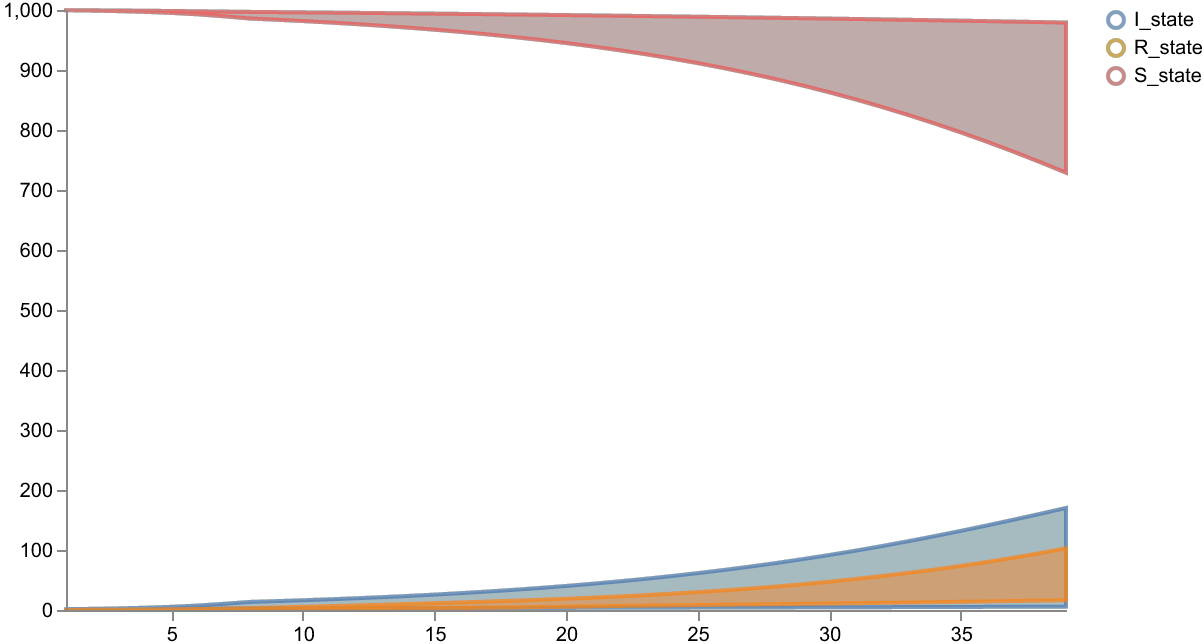

In [10]:
result2 = pyciemss.sample(
    model_opt1,
    end_time_SIR,
    logging_step_size,
    num_samples,
    start_time=start_time,
    static_parameter_interventions=static_parameter_interventions(opt_result2["policy"]),
    solver_method="euler",
    solver_options={"step_size": 1.},
)
# display(result2["data"])
# Check risk estimate used in constraints
print("Risk associated with QoI:", result2["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result2["data"], keep=".*_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

## Optimize interface with multiple interventions
### Optimizing multiple intervention values (SEIRHD)
Minimum change in two intervention parameters from their current values to get infections below 800 individuals at 40 days for SEIRHD model
* Intervene on beta_c after 10 days
* Intervene on gamma after 15 days

In [33]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(10.0), torch.tensor(15.0)]
intervened_params = ["beta_c", "gamma"]
param_current = [0.35, 0.2]
initial_guess_interventions = [0.2, 0.4]
bounds_interventions = [[0.1, 0.1], [0.5, 0.5]]
# Note that param_value is not passed in below and defaults to None.
# User can also pass ina list of lambda x: torch.tensor(x) for each intervention.
static_parameter_interventions = param_value_objective(
    param_name=intervened_params,
    start_time=intervention_time,
)

risk_bound = 3e4
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: np.sum(np.abs(param_current - x))

# Run optimize interface
opt_result3 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f"Optimal policy:", opt_result3["policy"])
print(opt_result3)

  0%|          | 0/60 [00:00<?, ?it/s]

[0.2 0.4]
Risk:  73081.50578124996
[0.2 0.4]


  2%|▏         | 1/60 [00:12<12:11, 12.40s/it]

Risk:  73081.50578124996
[0.25656854 0.4       ]


  3%|▎         | 2/60 [00:17<08:06,  8.39s/it]

Risk:  73081.50578124996
[0.25656854 0.45656854]


  5%|▌         | 3/60 [00:24<07:13,  7.61s/it]

Risk:  26481.18796874999
[0.31297558 0.45229703]


  7%|▋         | 4/60 [00:31<06:38,  7.12s/it]

Risk:  28534.347890624987
[0.369432   0.44873713]


  8%|▊         | 5/60 [00:37<06:19,  6.90s/it]

Risk:  30374.46042968749
[0.42599345 0.44784134]


 10%|█         | 6/60 [00:43<06:01,  6.69s/it]

Risk:  30857.032851562486
[0.37121195 0.47696534]


 12%|█▏        | 7/60 [00:50<05:48,  6.57s/it]

Risk:  18627.415703124992
[0.42597322 0.45049506]


 13%|█▎        | 8/60 [00:56<05:39,  6.53s/it]

Risk:  29450.547929687487
[0.39768507 0.45006531]


 15%|█▌        | 9/60 [01:02<05:27,  6.41s/it]

Risk:  29673.627617187485
[0.35533108 0.44981599]


 17%|█▋        | 10/60 [01:08<05:13,  6.26s/it]

Risk:  29803.870546874987
[0.34120946 0.44905438]


 18%|█▊        | 11/60 [01:15<05:18,  6.51s/it]

Risk:  30205.48257812499
[0.35479165 0.44276553]


 20%|██        | 12/60 [01:22<05:21,  6.69s/it]

Risk:  33749.251640624985
[0.34236653 0.44951952]


 22%|██▏       | 13/60 [01:28<05:06,  6.51s/it]

Risk:  29959.535273437486
[0.36239394 0.44947552]


 23%|██▎       | 14/60 [01:35<05:01,  6.56s/it]

Risk:  29982.701445312487
[0.35181195 0.4494758 ]


 25%|██▌       | 15/60 [01:42<05:00,  6.68s/it]

Risk:  29982.555703124985
[0.3482768  0.44942352]


 27%|██▋       | 16/60 [01:49<04:54,  6.69s/it]

Risk:  30010.121640624988
[0.34650911 0.44943998]


 28%|██▊       | 17/60 [01:56<04:57,  6.91s/it]

Risk:  30001.44480468749
[0.34828503 0.45030736]


 30%|███       | 18/60 [02:03<04:48,  6.87s/it]

Risk:  29547.75406249999
[0.35004446 0.44944299]


 32%|███▏      | 19/60 [02:10<04:47,  7.01s/it]

Risk:  29999.85824218749
[0.35181223 0.44944257]


 33%|███▎      | 20/60 [02:19<04:58,  7.46s/it]

Risk:  30000.076796874986
[0.23512897 0.32329753]
Risk:  309351.1281249999
[0.23512897 0.32329753]


 37%|███▋      | 22/60 [02:32<04:29,  7.10s/it]

Risk:  309351.1281249999
[0.29169751 0.32329753]


 38%|███▊      | 23/60 [02:39<04:22,  7.10s/it]

Risk:  309351.1281249999
[0.29169751 0.37986608]


 40%|████      | 24/60 [02:46<04:13,  7.03s/it]

Risk:  106172.21406249996
[0.34414019 0.40107374]


 42%|████▏     | 25/60 [02:53<04:01,  6.91s/it]

Risk:  71651.56781249997
[0.39581187 0.4240963 ]


 43%|████▎     | 26/60 [03:01<04:03,  7.16s/it]

Risk:  47108.92304687498
[0.36700298 0.41772586]


 45%|████▌     | 27/60 [03:06<03:40,  6.68s/it]

Risk:  52859.68234374998
[0.33581413 0.41250514]


 47%|████▋     | 28/60 [03:13<03:36,  6.76s/it]

Risk:  58121.31843749998
[0.34619861 0.43688775]


 48%|████▊     | 29/60 [03:19<03:20,  6.47s/it]

Risk:  37460.68929687499
[0.31968602 0.44674079]


 50%|█████     | 30/60 [03:25<03:16,  6.55s/it]

Risk:  31461.071289062485
[0.3578149  0.44495384]


 52%|█████▏    | 31/60 [03:33<03:18,  6.85s/it]

Risk:  32468.623554687485
[0.34455627 0.44376545]


 53%|█████▎    | 32/60 [03:42<03:30,  7.53s/it]

Risk:  33157.57867187499
[0.33957882 0.4487879 ]


 55%|█████▌    | 33/60 [03:52<03:43,  8.29s/it]

Risk:  30347.36085937499
[0.34663726 0.4483655 ]


 57%|█████▋    | 34/60 [04:00<03:28,  8.01s/it]

Risk:  30573.680937499987
[0.35363673 0.44936922]


 58%|█████▊    | 35/60 [04:05<03:03,  7.33s/it]

Risk:  30038.770624999986
[0.34656568 0.44938263]


 60%|██████    | 36/60 [04:13<03:01,  7.56s/it]

Risk:  30031.693437499987
[0.33949484 0.44944028]


 62%|██████▏   | 37/60 [04:20<02:44,  7.15s/it]

Risk:  30001.28695312499
[0.35010078 0.44943809]


 63%|██████▎   | 38/60 [04:26<02:29,  6.81s/it]

Risk:  30002.436796874987
[0.3536363  0.44944537]


 65%|██████▌   | 39/60 [04:31<02:16,  6.49s/it]

Risk:  29998.598710937487
[0.35009714 0.45120586]


 67%|██████▋   | 40/60 [04:38<02:09,  6.49s/it]

Risk:  29085.479765624987
[0.34656524 0.44944291]


 68%|██████▊   | 41/60 [04:45<02:06,  6.67s/it]

Risk:  29999.886796874987
[0.39214577 0.40638739]
Risk:  64993.25531249997
[0.39214577 0.40638739]


 72%|███████▏  | 43/60 [05:02<02:07,  7.48s/it]

Risk:  64993.25531249997
[0.44871431 0.40638739]


 73%|███████▎  | 44/60 [05:10<02:00,  7.53s/it]

Risk:  64993.25531249997
[0.39214577 0.46295593]


 75%|███████▌  | 45/60 [05:16<01:49,  7.33s/it]

Risk:  23698.487539062487
[0.36211057 0.45432366]


 77%|███████▋  | 46/60 [05:22<01:37,  6.99s/it]

Risk:  27539.90335937499
[0.3063668  0.44469907]


 78%|███████▊  | 47/60 [05:29<01:29,  6.87s/it]

Risk:  32615.043437499986
[0.39033908 0.45254848]


 80%|████████  | 48/60 [05:35<01:19,  6.64s/it]

Risk:  28408.92820312499
[0.34824181 0.45155645]


 82%|████████▏ | 49/60 [05:41<01:12,  6.55s/it]

Risk:  28907.190195312487
[0.33410881 0.45104797]


 83%|████████▎ | 50/60 [05:48<01:05,  6.54s/it]

Risk:  29166.13578124999
[0.3468582  0.45849083]


 85%|████████▌ | 51/60 [05:55<01:01,  6.80s/it]

Risk:  25608.923749999987
[0.3342703  0.44936621]


 87%|████████▋ | 52/60 [06:03<00:55,  6.98s/it]

Risk:  30040.362031249984
[0.34153634 0.44931217]


 88%|████████▊ | 53/60 [06:10<00:49,  7.00s/it]

Risk:  30068.904296874985
[0.3508766  0.44919894]


 90%|█████████ | 54/60 [06:17<00:42,  7.05s/it]

Risk:  30128.817968749987
[0.35440331 0.44944852]


 92%|█████████▏| 55/60 [06:23<00:33,  6.73s/it]

Risk:  29996.93410156249
[0.34735011 0.44945173]


 93%|█████████▎| 56/60 [06:29<00:26,  6.65s/it]

Risk:  29995.237343749985
[0.34912667 0.44944943]


 95%|█████████▌| 57/60 [06:35<00:19,  6.49s/it]

Risk:  29996.459335937485
[0.34824284 0.4494396 ]


 97%|█████████▋| 58/60 [06:42<00:13,  6.55s/it]

Risk:  30001.63589843749
[0.34912175 0.44989135]


 98%|█████████▊| 59/60 [06:49<00:06,  6.53s/it]

Risk:  29764.440820312488
[0.35001053 0.44944266]


100%|██████████| 60/60 [06:56<00:00,  6.71s/it]

Risk:  30000.031132812488
[0.35089441 0.44944276]


61it [07:00,  6.12s/it]                        

Risk:  29999.985468749986
[0.34956859 0.44944272]


63it [07:07,  6.79s/it]

Risk:  30000.001093749986
Optimal policy: tensor([0.3501, 0.4495], dtype=torch.float64)
{'policy': tensor([0.3501, 0.4495], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: 0.24948745014993085
                          x: [ 3.501e-01  4.495e-01]
                        nit: 2
      minimization_failures: 3
                       nfev: 60
 lowest_optimization_result: message: Maximum number of function evaluations has been exceeded.
                             success: False
                              status: 2
                                 fun: 0.24948745014993085
                                   x: [ 3.500e-01  4.494e-01]
                                nfev: 20
                               maxcv: 0.0}
Intervention:  {10.0: {'beta_c': tensor(0.3501)}, 15.0: {'gamma': tensor(0.4495)}}


#### Sample using optimal policy as intervention

Intervention:  {0.3501: {'beta_c': tensor(0.1500)}, 0.4495: {'gamma': tensor(0.4000)}}
Risk associated with QoI: [20833.862460937497]


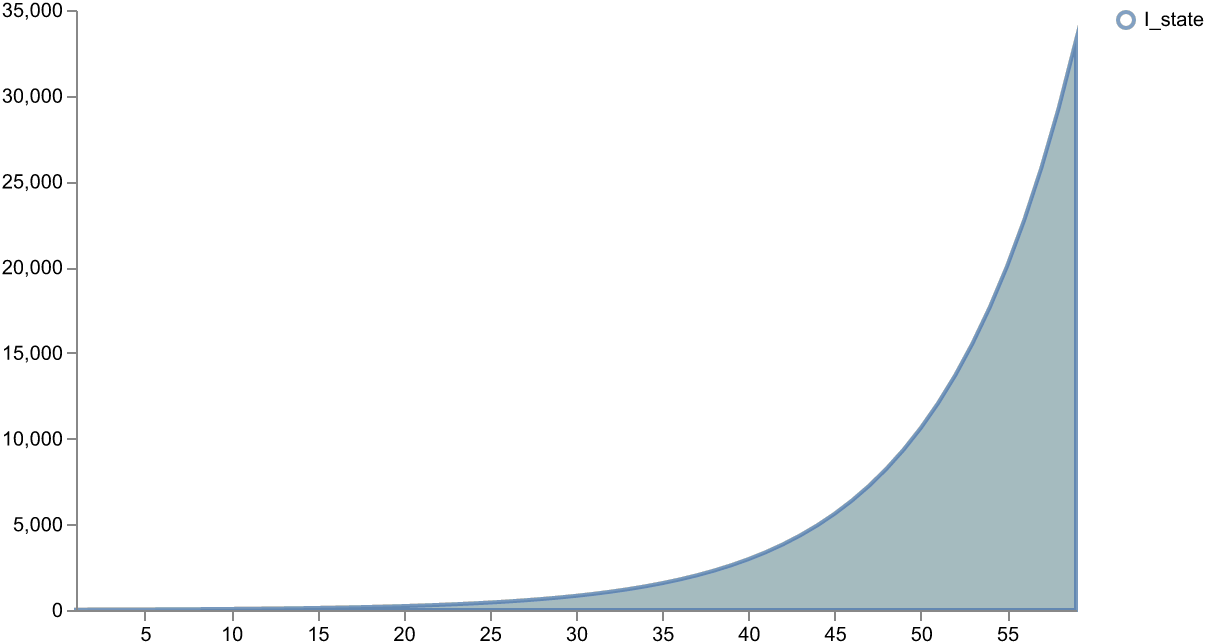

In [46]:
print("Intervention: ", static_parameter_interventions(opt_result3["policy"]))
with pyro.poutine.seed(rng_seed=0):
    result3 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result3["policy"]),
        solver_method="rk4",
        solver_options={"step_size": 1.},
    )

# Check risk estimate used in constraints
print("Risk associated with QoI:", result3["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result3["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

### Optimizing for start times of multiple interventions (SEIRHD)
Maximum delay in starting two interventions to get infections below 800 individuals at 40 days for SEIRHD model
* Intervene on beta_c to be 0.15
* Intervene on gamma to be 0.35

In [42]:
# Define optimization problem setup
observed_params = ["I_state"]
intervened_params = ["beta_c", "gamma"]
initial_guess_interventions = [torch.tensor(10.), torch.tensor(10.)]
bounds_interventions = [[1., 1.], [39., 39.]]    # bounds should be withing start_time and end_time
intervention_value = torch.tensor([0.15, 0.4])
static_parameter_interventions = start_time_objective(
    param_name = intervened_params,
    param_value = intervention_value,
)

risk_bound = 3e4
qoi = lambda y: obs_nday_average_qoi(y, observed_params, 1)
objfun = lambda x: -np.sum(np.abs(x))

# Run optimize interface
opt_result4 = pyciemss.optimize(
    model_opt2,
    end_time_SEIRHD,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
    solver_method="rk4",
    solver_options={"step_size": 1.},
)
print(f'Optimal policy:', opt_result4["policy"])
print(opt_result4)
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))

[10. 10.]
Risk:  43519.40914062498
[10. 10.]


Risk:  43519.40914062498
[15.37401154 10.        ]


Risk:  43587.33906249999
[15.37401154 15.37401154]


Risk:  76154.93843749996
[20.25329699  7.74776257]


Risk:  35113.78468749999
[25.33983332  6.01364948]


Risk:  29996.83015624999
[30.63356764  5.08824315]


Risk:  27754.450859374992
[36.00628664  4.97038476]


Risk:  27443.171796874994
[39.          5.47649577]


Risk:  28611.84054687499
[38.55209593  8.12590739]


Risk:  36392.321328124985
[39.66235291  5.58847179]
[37.67475149  5.25577789]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  28137.694531249992
[39.          5.95269362]


Risk:  29791.16820312499
[39.33587572  5.95269362]
[38.3282493   5.95369149]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  29839.51570312499
[39.          6.03701731]


Risk:  30011.62648437499
[39.08396893  6.03701731]
[38.83206215  6.03707984]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  30042.09109374999
[39.02099223  6.03701731]
[38.95801554  6.03702122]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  30020.441718749993
[38.99999902  6.02652119]


Risk:  29983.95124999999
[36.62703774  1.        ]
Risk:  21276.361601562494
[36.62703774  1.        ]


Risk:  21276.361601562494
[42.00104927  1.        ]
[36.62703774  6.37401154]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  30969.32796874999
[31.25479118  6.51173202]


Risk:  31344.26757812499
[39.        5.867581]


Risk:  29572.71749999999
[39.14020578  6.52453788]
[38.72257327  4.55303377]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  26591.96851562499
[39.32863681  5.79822432]
[38.34297237  6.00745483]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  29980.712578124992
[39.          6.05372578]


Risk:  30055.78976562499
[39.08396893  6.05372578]
[38.83206215  6.05378829]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  30086.30117187499
[39.00001563  6.09571025]
[38.99998438  5.96975685]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  29835.21554687499
[39.          6.03248782]


Risk:  29999.68789062499
[39.02099223  6.03248782]
[38.95801554  6.03249173]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  30008.50156249999
[39.00524806  6.03248782]
[38.98950388  6.03248807]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  30001.96593749999
[39.00000006  6.03511185]
[39.          5.49236652]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  28649.64304687499
[39.          5.49236652]


Risk:  28649.64304687499
[44.37401154  5.49236652]
[39.         10.86637806]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  47488.882890624984
[33.62729186 10.98473044]


Risk:  48137.36039062498
[40.34350288  5.49236652]
[36.31304095  5.50821099]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  28730.63843749999
[39.00396112  6.16410629]
[38.99606219  4.14886941]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  25754.11007812499
[39.          6.11890322]


Risk:  30228.77695312499
[39.33587572  6.11890322]
[38.32824929  6.11989743]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  30277.760312499988
[39.          6.02813374]
[39.08396893  6.11890322]
[38.87654579  6.2327548 ]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0


Risk:  30557.898124999992
[39.          6.20287215]
[39.          6.16088768]
[38.97900777  6.11890322]


C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0
C:\Users\Anirban\Documents\GitHub\pyciemss\pyciemss\ouu\ouu.py:99: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  self.u_bounds[1, :] - x < 0.0
63it [02:59,  2.84s/it]                        

Risk:  30233.314765624993
[39.          6.07691875]
[39.          6.09791098]
[39.          6.12939933]
Optimal policy: tensor([39.0000,  6.0371], dtype=torch.float64)
{'policy': tensor([39.0000,  6.0371], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: False
                        fun: -45.03701730689251
                          x: [ 3.900e+01  6.037e+00]
                        nit: 2
      minimization_failures: 3
                       nfev: 60
 lowest_optimization_result: message: Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.
                             success: False
                              status: 4
                                 fun: -45.03701730689251
                                   x: [ 3.900e+01  6.037e+00]
                                nfev: 20
                               maxcv: 11.626484

Intervention:  {39.0: {'beta_c': tensor(0.1500)}, 6.0371: {'gamma': tensor(0.4000)}}
Time taken:  6.549503326416016
Risk associated with QoI: [30011.84273437499]


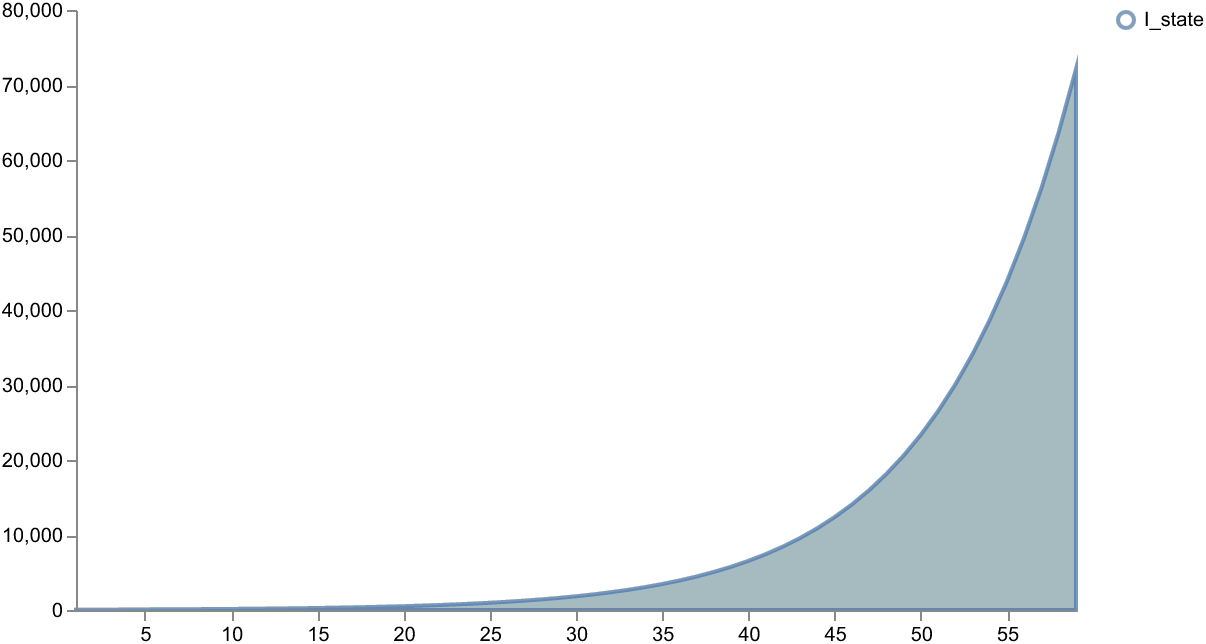

In [52]:
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="rk4",
        # solver_method="euler",
        solver_options={"step_size":1.},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

Intervention:  {39.0: {'beta_c': tensor(0.1500)}, 6.0371: {'gamma': tensor(0.4000)}}
Time taken:  10.559374809265137
Risk associated with QoI: [28499.983671874994]


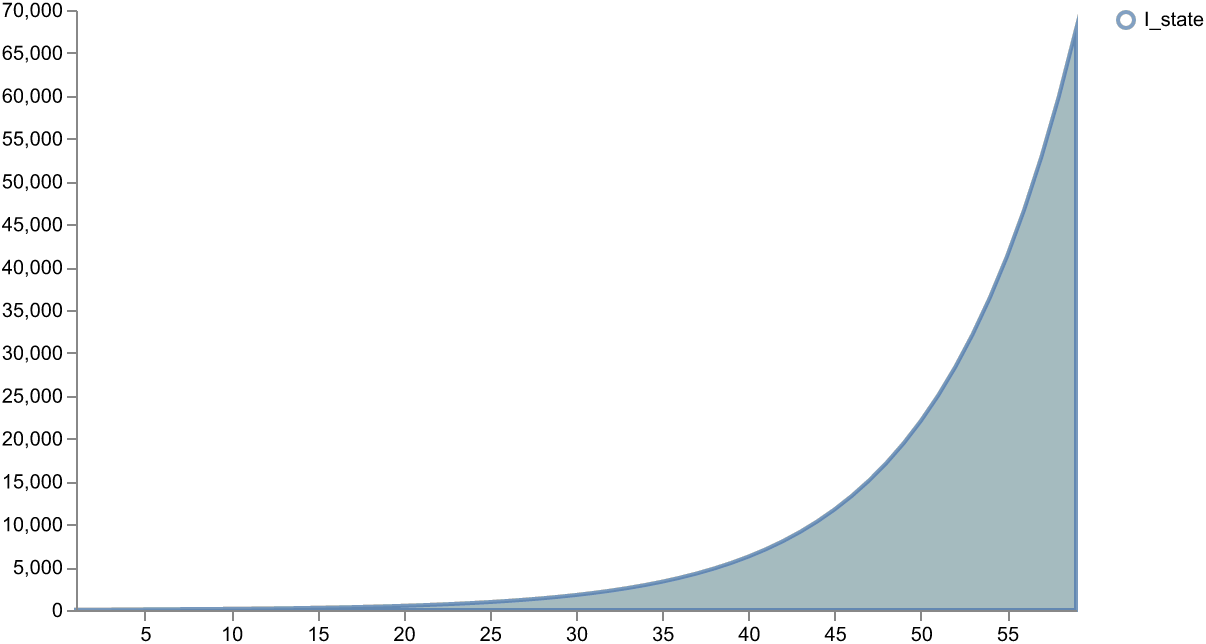

In [48]:
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="euler",
        solver_options={"step_size": 0.1},
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)

Intervention:  {39.0: {'beta_c': tensor(0.1500)}, 6.0371: {'gamma': tensor(0.4000)}}
Time taken:  11.904982328414917
Risk associated with QoI: [30012.84773437499]


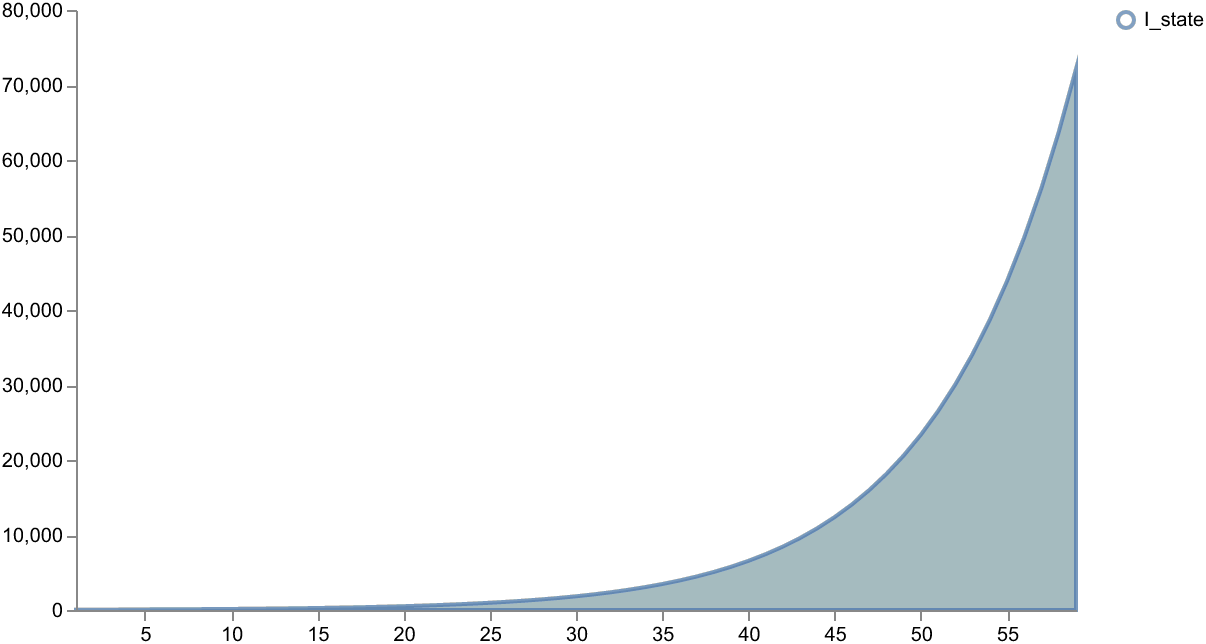

In [49]:
print("Intervention: ", static_parameter_interventions(opt_result4["policy"]))
start_t = time.time()
with pyro.poutine.seed(rng_seed=0):
    result4 = pyciemss.sample(
        model_opt2,
        end_time_SEIRHD,
        logging_step_size,
        num_samples,
        start_time=start_time,
        static_parameter_interventions=static_parameter_interventions(opt_result4["policy"]),
        solver_method="dopri5",
    )
print("Time taken: ", time.time()-start_t)
# Check risk estimate used in constraints
print("Risk associated with QoI:", result4["risk"][observed_params[0]]["risk"])
# Plot results for all states
schema = plots.trajectories(result4["data"], keep="I_state", qlow=0.0, qhigh=1.0)
plots.ipy_display(schema, dpi=150)